# Sentiment Analysis

Sentiment analysis is the process of categorizing opinions in natural language text. Several methods can be used to estimate sentiment. In this example, labeled reviews from Yelp, Amazon, and IMDB are used to train a supervised binary classification model. The model is a 1D convolutional neural network (CNN). While 2D CNNs are commonly used for image classification, their exceptional spatial capabilities can applied to text in one dimension.

Words in a sentence must be encoded as vectors for training and prediction. This encoding is more commonly called embedding. A straightforward approach would assign every distinct word a unique numerical value. A better approach is use pretrained word embeddings based on a large corpus of text, such as Wikipedia. Global Vectors for Word Representation ([GloVe](https://nlp.stanford.edu/projects/glove/)) is a popular vector representation based on word co-occurance.

This is a Tensorflow 1.x notebook!

In [ ]:
%tensorflow_version 1.x

In [1]:
import pandas as pd
import numpy as np
import random

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, GlobalMaxPooling1D, Embedding
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Training Data

Data is loaded into a Pandas data frame from text files. This dataset contains two columns: a natural language comment and binary positive/negative sentiment represented as 1 or 0.

In [2]:
# Download data from https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences

files = ['data/yelp_labelled.txt', 'data/amazon_cells_labelled.txt', 'data/imdb_labelled.txt']

df_list = []
for file in files:
    df = pd.read_csv(file, names=['comment', 'sentiment'], sep='\t')
    df_list.append(df)

trainingData = pd.concat(df_list)

print('Number of rows: %d' % len(trainingData))

trainingData.head(10)

Number of rows: 2748


,comment,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
5,Now I am getting angry and I want my damn pho.,0
6,Honeslty it didn't taste THAT fresh.),0
7,The potatoes were like rubber and you could te...,0
8,The fries were great too.,1
9,A great touch.,1


In [3]:
MAX_NB_WORDS = 20000
MAX_SEQUENCE_LENGTH = 1000
EMBEDDING_DIM = 50

num_classes = 2

# GloVE Embeddings

These are some convenience functions for loading GloVE vectors and creating an embedding matrix.

In [4]:
def load_glove_vectors():
    print('Loading glove vectors...')
    glove_map = {}
    with open('data/glove.6B.%dd.txt' % EMBEDDING_DIM, encoding='utf8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            glove_map[word] = np.asarray(values[1:], dtype='float32')
    return glove_map

def create_embedding_matrix(word_index, num_words):
    glove_map = load_glove_vectors()
    embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i > num_words:
            continue
        vector = glove_map.get(word)
        if vector is not None:
            embedding_matrix[i] = vector
    return embedding_matrix

# Encode Text

In [5]:
comments = trainingData.comment.astype(str).tolist()
sentiments = trainingData.sentiment.tolist()
labels = np.asarray(sentiments)

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(comments)
sequences = tokenizer.texts_to_sequences(comments)
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index

num_words = min(MAX_NB_WORDS, len(word_index)) + 1

x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2)

In [6]:
embedding_matrix = create_embedding_matrix(word_index, num_words)

Loading glove vectors...


# Define Model

This is a 1D CNN model with a Keras embedding layer using the embedding matrix created above. The embedding layer is pre-trained, so it will not be trained here.

In [7]:
dropout = 0.4

model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(Dropout(dropout))

model.add(Conv1D(128, 5, activation='relu', padding='same', strides=2))
model.add(GlobalMaxPooling1D())
model.add(Dropout(dropout))

model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 50)          263600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000, 50)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 128)          32128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)      

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 2198 samples, validate on 550 samples
Epoch 1/40
2198/2198 [==============================] - 6s 3ms/step - loss: 0.8654 - acc: 0.5114 - val_loss: 0.6773 - val_acc: 0.5436
Epoch 2/40
2198/2198 [==============================] - 5s 2ms/step - loss: 0.7253 - acc: 0.5409 - val_loss: 0.6634 - val_acc: 0.6655
Epoch 3/40
2198/2198 [==============================] - 5s 2ms/step - loss: 0.6824 - acc: 0.5746 - val_loss: 0.6488 - val_acc: 0.6891
Epoch 4/40
2198/2198 [==============================] - 5s 2ms/step - loss: 0.6750 - acc: 0.5828 - val_loss: 0.6362 - val_acc: 0.7218
Epoch 5/40
2198/2198 [==============================] - 5s 2ms/step - loss: 0.6495 - acc: 0.6338 - val_loss: 0.6231 - val_acc: 0.7291
Epoch 6/40
2198/2198 [==============================] - 5s 2ms/step - loss: 0.6404 - acc: 0.6338 - val_loss: 0.5992 - val_acc: 0.7418
Epoch 7/40
2198/2198 [=

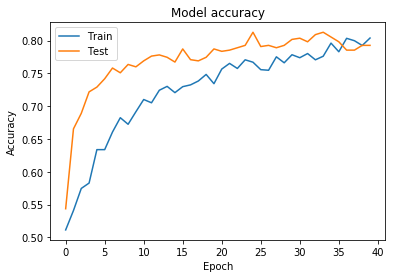

In [8]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['acc'])

# Train model for a given number of epochs
history = model.fit(x_train, y_train, batch_size=128, epochs=40, verbose=1, validation_data=(x_test, y_test))

# Evaluate model against test data
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Prediction

In [9]:
predictions = model.predict(padded_sequences)
most_likely = predictions.argmax(1)

In [10]:
index = random.randrange(len(predictions))
print(comments[index])
print('Prediction: %d, label: %d' % (most_likely[index], sentiments[index]))

I was not impressed by this product.
Prediction: 0, label: 0


# Error Analysis

Its not user friendly.
Prediction: 1, label: 0


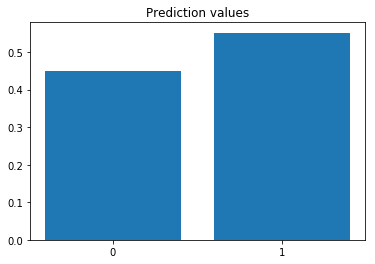

In [11]:
for i in range(10000):
    index = random.randrange(len(predictions))
    if most_likely[index] != sentiments[index]:
        break

print(comments[index])
print('Prediction: %d, label: %d' % (most_likely[index], sentiments[index]))

plt.bar(range(num_classes), predictions[index], tick_label=range(num_classes))
plt.title('Prediction values')
plt.show()